## Reading and cleaning up the data

##### The data is from the [NOAA Climate Data Online tool](https://www.ncdc.noaa.gov/cdo-web/)

##### Documentation including details for each variable can be found at [this link](https://www.ncei.noaa.gov/data/daily-summaries/doc/GHCND_documentation.pdf) 

In [51]:
import datetime
import matplotlib.pyplot as plt # Import matplotlib for plotting and use magic command for Jupyter Notebooks
%matplotlib inline
import numpy as np
import pandas as pd # Pandas is used for data manipulation

# Read in data and display first 5 rows
conditions_df = pd.read_csv('weatherData_KSEA_2000-2024_full_year.csv')
conditions_df.head(5)

,STATION,DATE,AWND,FMTM,PGTM,PRCP,SNOW,SNWD,TAVG,TMAX,...,WT14,WT15,WT16,WT17,WT18,WT19,WT21,WT22,WV01,WV03
0,USW00024233,2000-01-01,12.30,450.0,457.0,0.27,NaN,NaN,40.0,43,...,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,USW00024233,2000-01-02,8.95,611.0,339.0,0.00,NaN,NaN,25.0,45,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,USW00024233,2000-01-03,9.40,2121.0,2120.0,0.28,NaN,NaN,42.0,47,...,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,USW00024233,2000-01-04,13.42,928.0,933.0,0.30,NaN,NaN,46.0,50,...,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,USW00024233,2000-01-05,6.71,1209.0,1646.0,0.00,NaN,NaN,41.0,44,...,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [52]:
# Check if TAVG is between TMIN and TMAX
# Select the rows where TAVG is not between TMIN and TMAX
invalid_rows = conditions_df[(conditions_df['TAVG'] < conditions_df['TMIN']) | (conditions_df['TAVG'] > conditions_df['TMAX'])]

# Count the number of invalid rows
invalid_count = len(invalid_rows)

# Print the count of invalid rows
print(f"Number of invalid rows where TAVG is not between TMIN and TMAX: {invalid_count}")

# Print the dates, TAVG, TMIN, and TMAX of the invalid rows
if invalid_count > 0:
    print("Dates of invalid rows with TAVG, TMIN, TMAX:")
    print(invalid_rows[['DATE', 'TAVG', 'TMIN', 'TMAX']])

    # Set TAVG, TMIN, TMAX to NaN for these invalid rows
    conditions_df.loc[(conditions_df['TAVG'] < conditions_df['TMIN']) | (conditions_df['TAVG'] > conditions_df['TMAX']), ['TAVG', 'TMIN', 'TMAX']] = np.nan
else:
    print("All rows are valid.")

Number of invalid rows where TAVG is not between TMIN and TMAX: 15
Dates of invalid rows with TAVG, TMIN, TMAX:
            DATE  TAVG  TMIN  TMAX
1     2000-01-02  25.0  37.0    45
459   2001-04-04  82.0  34.0    67
561   2001-07-15  65.0  52.0    59
1433  2003-12-04   0.0  39.0    51
1488  2004-01-28  41.0  44.0    49
5235  2014-05-02  66.0  51.0    65
5704  2015-08-14  67.0  59.0    65
5978  2016-05-14  61.0  53.0    58
7079  2019-05-20  58.0  52.0    57
7308  2020-01-04  47.0  40.0    46
7468  2020-06-12  60.0  53.0    59
8203  2022-06-17  58.0  53.0    57
8364  2022-11-25  47.0  37.0    46
8560  2023-06-09  58.0  52.0    56
9001  2024-08-23  60.0  55.0    59


In [53]:
# Drop the station column as they are all the same state SeaTac
conditions_df.drop(columns=['STATION'], inplace=True, errors='ignore')

In [54]:
# Drop the columns with names 'SNOW', 'SNWD', 'TSUN' if they exist as they are unfortunately unreliable
# Note: these specific variables seems to be missing at different time periods, may want to look into
conditions_df.drop(columns=['FMTM', 'PGTM', 'SNOW', 'SNWD', 'TSUN', 'WESD'], inplace=True, errors='ignore')

In [55]:
# Replace NaN in columns WT01 through WT22, WV01 and WV03 with 0
columns_to_fill = [f'WT{i:02d}' for i in range(1, 23)] + ['WV01', 'WV03']

# Fill NaN values with 0 for specified columns
for column_name in columns_to_fill:
    if column_name in conditions_df.columns:
        conditions_df[column_name].fillna(0, inplace=True)

/var/folders/3z/5v98g12j11xbhlhr8t6yvknw0000gn/T/ipykernel_80937/983992007.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  conditions_df[column_name].fillna(0, inplace=True)


In [56]:
# Loop through all columns, excluding 'date' (since we don't need a 1d or 2d prior 'date' column)
for column in conditions_df.columns:
    if column != 'DATE':  # Skip the 'date' column
        # Create columns for variables from 1 and 2 days prior using shift
        conditions_df[f'{column}_1d_prior'] = conditions_df[column].shift(1)
        conditions_df[f'{column}_2d_prior'] = conditions_df[column].shift(2)

In [57]:
# Drop all original columns except for 'date' and 'temp_actual'
columns_to_drop = [col for col in conditions_df.columns if col not in ['DATE', 'TAVG'] and '_prior' not in col]
conditions_df.drop(columns=columns_to_drop, inplace=True)

In [58]:
# Rename 'avg_temp' to 'temp_actual'
conditions_df.rename(columns={'TAVG': 'TAVG_ACTUAL'}, inplace=True)

In [59]:
# Drop the first two rows as they don't have prior data
conditions_df.drop(index=[0, 1], inplace=True)

In [60]:
# Remove rows where data is missing or wasn't physical (NaN values)
conditions_df.dropna(inplace=True)

In [61]:
# Shows first 5 rows
conditions_df.head(5)

,DATE,TAVG_ACTUAL,AWND_1d_prior,AWND_2d_prior,PRCP_1d_prior,PRCP_2d_prior,TAVG_1d_prior,TAVG_2d_prior,TMAX_1d_prior,TMAX_2d_prior,...,WT19_1d_prior,WT19_2d_prior,WT21_1d_prior,WT21_2d_prior,WT22_1d_prior,WT22_2d_prior,WV01_1d_prior,WV01_2d_prior,WV03_1d_prior,WV03_2d_prior
4,2000-01-05,41.0,13.42,9.40,0.30,0.28,46.0,42.0,50.0,47.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,2000-01-06,37.0,6.71,13.42,0.00,0.30,41.0,46.0,44.0,50.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,2000-01-07,43.0,5.59,6.71,0.03,0.00,37.0,41.0,41.0,44.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,2000-01-08,41.0,8.95,5.59,0.21,0.03,43.0,37.0,46.0,41.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,2000-01-09,40.0,14.32,8.95,0.32,0.21,41.0,43.0,46.0,46.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [62]:
print('The shape of our features is:', conditions_df.shape)

The shape of our features is: (6150, 62)


In [63]:
# Descriptive statistics for each column
conditions_df.describe()

,TAVG_ACTUAL,AWND_1d_prior,AWND_2d_prior,PRCP_1d_prior,PRCP_2d_prior,TAVG_1d_prior,TAVG_2d_prior,TMAX_1d_prior,TMAX_2d_prior,TMIN_1d_prior,...,WT19_1d_prior,WT19_2d_prior,WT21_1d_prior,WT21_2d_prior,WT22_1d_prior,WT22_2d_prior,WV01_1d_prior,WV01_2d_prior,WV03_1d_prior,WV03_2d_prior
count,6150.000000,6150.000000,6150.000000,6150.000000,6150.000000,6150.000000,6150.000000,6150.000000,6150.000000,6150.000000,...,6150.000000,6150.000000,6150.000000,6150.000000,6150.000000,6150.000000,6150.000000,6150.000000,6150.000000,6150.000000
mean,53.477886,7.495161,7.499200,0.104387,0.104821,53.469919,53.459024,61.226667,61.210569,46.293333,...,0.000813,0.000813,0.012683,0.012683,0.002439,0.002439,0.001301,0.001301,0.000650,0.000650
std,10.536175,2.989889,2.991685,0.247907,0.248762,10.522919,10.505868,13.054311,13.036611,8.963949,...,0.028504,0.028504,0.111911,0.111911,0.049330,0.049330,0.036046,0.036046,0.025497,0.025497
min,17.000000,0.000000,0.000000,0.000000,0.000000,17.000000,17.000000,22.000000,22.000000,15.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,45.000000,5.370000,5.370000,0.000000,0.000000,45.000000,45.000000,51.000000,51.000000,39.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,53.000000,6.930000,6.930000,0.000000,0.000000,53.000000,53.000000,60.000000,60.000000,47.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,62.000000,9.170000,9.170000,0.090000,0.090000,62.000000,62.000000,71.000000,71.000000,54.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,91.000000,21.030000,21.030000,5.020000,5.020000,91.000000,91.000000,108.000000,108.000000,73.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Visually checking the data

In [64]:
dates = [datetime.datetime.strptime(date, '%Y-%m-%d') for date in conditions_df['DATE']]

Text(0.5, 1.0, 'Presence of Hail')

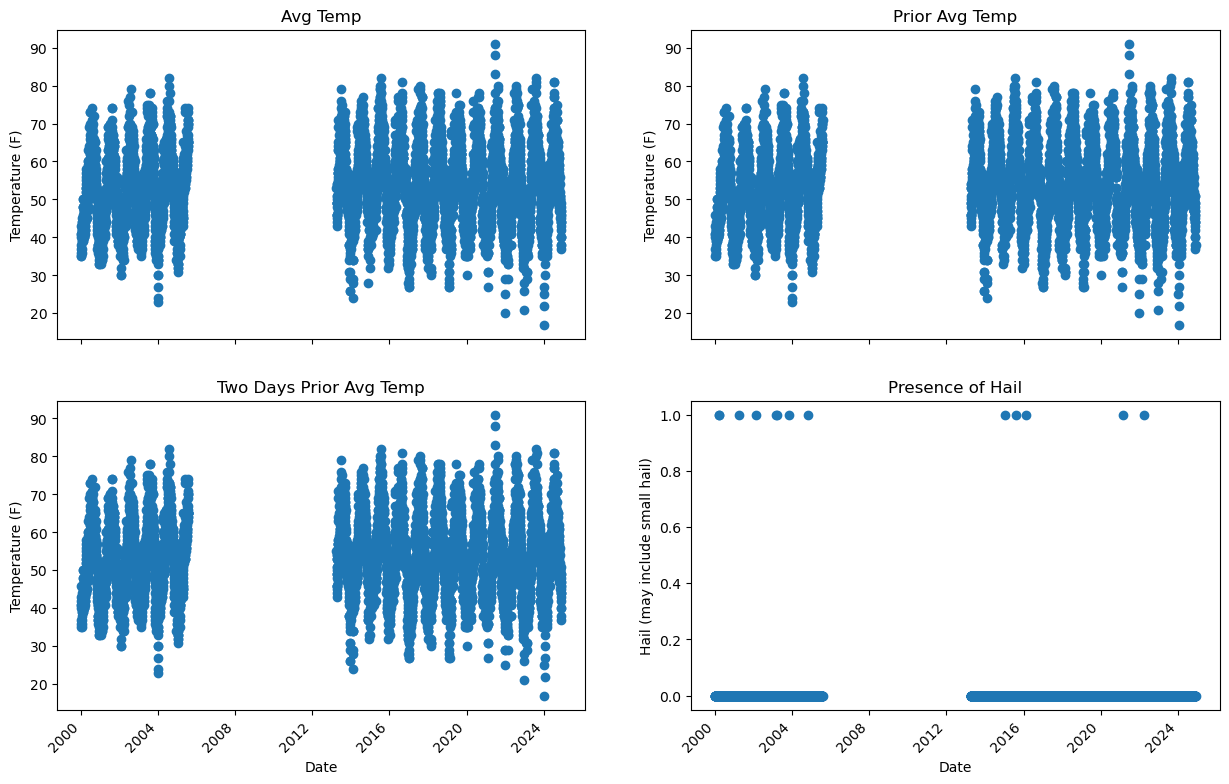

In [65]:
# Set up the plotting layout
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize = (15,10))
fig.autofmt_xdate(rotation = 45)

# Actual avg temperature measurement
ax1.scatter(dates, conditions_df['TAVG_ACTUAL'])
ax1.set_xlabel(''); ax1.set_ylabel('Temperature (F)'); ax1.set_title('Avg Temp')

# Temperature from 1 day ago
ax2.scatter(dates, conditions_df['TAVG_1d_prior'])
ax2.set_xlabel(''); ax2.set_ylabel('Temperature (F)'); ax2.set_title('Prior Avg Temp')

# Temperature from 2 days ago
ax3.scatter(dates, conditions_df['TAVG_2d_prior'])
ax3.set_xlabel('Date'); ax3.set_ylabel('Temperature (F)'); ax3.set_title('Two Days Prior Avg Temp')

# Temperature from 2 days ago
ax4.scatter(dates, conditions_df['WT05_1d_prior'])
ax4.set_xlabel('Date'); ax4.set_ylabel('Hail (may include small hail)'); ax4.set_title('Presence of Hail')

For some reason, the TAVG (Avg Temp) dismid-2005 to early-2013